## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings


Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO

but Gdown can't. Please check connections and permissions.


In [ ]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW

but Gdown can't. Please check connections and permissions.


In [120]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

--2024-02-01 15:33:18--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.129.233, 52.217.200.49, 52.216.153.68, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.129.233|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip.1’

val2014.zip.1       100%[===================>]   6.19G  15.7MB/s    in 7m 18s  

2024-02-01 15:40:37 (14.5 MB/s) - ‘val2014.zip.1’ saved [6645013297/6645013297]

Archive:  /content/val2014.zip
replace val2014/COCO_val2014_000000324670.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: --2024-02-01 15:42:35--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.99.25, 52.216.77.116, 52.217.97.4, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.99.25|:80... connected.
HTTP request sent, awaiting r

In [147]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [123]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=1.91s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [124]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [125]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [126]:
# cap_path = '/content/coco_captions.npy'
cap_path = '/content/drive/MyDrive/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [127]:
# img_path = '/content/coco_imgs.npy'
img_path = '/content/drive/MyDrive/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [157]:
def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre) , weights=(1,))
        accuracy += score
    return accuracy/len(predict)

In [129]:
cembeds_img={}
for i in range(caption_embeddings.shape[0]):
  capt=tuple(tuple(x) for x in caption_embeddings[i])
  cembeds_img[capt]=i

In [131]:
from sklearn.model_selection import train_test_split
#print(captions_np.shape)

#We have to store all the captions i.e for each image there are 5 captions so we stores everything into one array
caption_for_images = []
for i in range(captions_np.shape[0]):
  caption_for_images.append(captions_np[i])


caption_for_images = np.array(caption_for_images)

caption_and_embeds = list(zip(caption_embeddings , caption_for_images))

img_train , img_test ,captions_train ,captions_test = train_test_split(image_embeddings , caption_and_embeds, test_size = 0.2, random_state = None )

In [135]:
def query_vector(knearest_dist,knearest_ind,k):
    res = np.zeros((512))
    for dist,ind  in zip(knearest_dist, knearest_ind): # iterates through all the k nearest images
        weight = 1 - dist #gives more preference to closest distanced image
        sum = np.sum(captions_train[ind][0], axis=0) # adds up all(5) caption vectors of that image
        res += weight * sum
    res /= k * 5
    return res

In [136]:
def get_caption(tmp,ind):
  res=1
  for i in ind:
    for j in range(5):
      #cosine similarity
        cal = np.dot(captions_train[i][0][j],tmp)/((np.linalg.norm(captions_train[i][0][j]))*(np.linalg.norm(tmp)))
        if abs(cal) < res:
            res=abs(cal)
            best_caption=captions_train[i][1][j]
  return best_caption


In [158]:
#finding k-nearest neighbors using faiss.knn
k_values=[3,5,7,10]
scores=[]
best_score=0
best_ans=[]
for k in k_values:
  #for every test image, it finds k nearest (img_dist,indices) in train data
  dist,indices=faiss.knn(img_test,img_train,k)
  query_captions=[]
  for ind,dis in zip(indices,dist): #for every test image calculating the average of their k nearest images
    query_captions.append(query_vector(dis,ind,k))
  query_captions=np.array(query_captions)
  ans=[]
  for i in range(len(query_captions)):
    ans.append(get_caption(query_captions[i],indices[i]))
  Cap_test = [caps[1] for caps in captions_test]
  ans = np.array(ans)
  Cap_test = np.array(Cap_test)
  blue_score = accuracy_v2(ans , Cap_test)
  scores.append(blue_score)
  if(blue_score>best_score):
    best_score=blue_score
    best_ans=ans

In [159]:
for i,j in zip(k_values,scores):
  print("Bleu_score for k =",i,"is:",j)

Bleu_score for k = 3 is: 0.4211718819191302
Bleu_score for k = 5 is: 0.4057548200929639
Bleu_score for k = 7 is: 0.39667648259600874
Bleu_score for k = 10 is: 0.3863156137646431


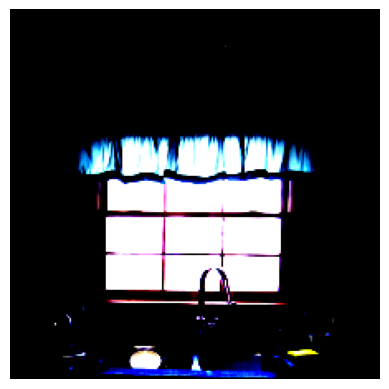


Actual captions: 
=>  A kitchen sink sitting underneath a large wooden window.
=>  a kitchen sink sits in front of a window 
=>  A window over a sink in a kitchen.
=>  A window with so Michael light coming inside
=>  A clock that is hanging on a wall above a window.

Predicted Caption =>  Two boys sitting at a table while eating.



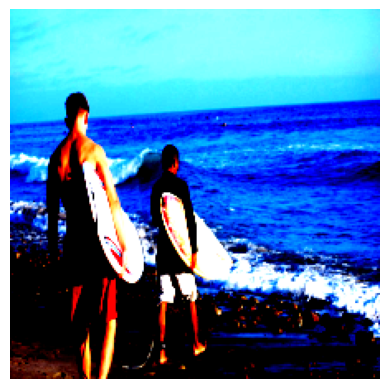


Actual captions: 
=>  Two men are walking towards the ocean with their surfboards. 
=>  Two men with surfboards walk toward the beach
=>  Two men with surfboards walk towards the ocean.
=>  Two people about to go into the water with their surfboards
=>  Two servers holding their boards walking towards the water. 

Predicted Caption =>  a male surfer in black shorts carrying a white board



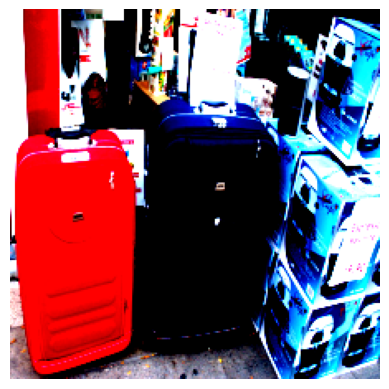


Actual captions: 
=>  A couple of large suitcases on the ground.
=>  A sidewalk sale with luggage sets and boxes of espresso machines on display
=>  Luggage and espresso machines for sale in a store.
=>  A red suitcase and blue suitcase sit beside espresso machines.
=>  The two suitcases are together outside to be sold.

Predicted Caption =>  A pile of different colored bags of luggage sitting on a floor.



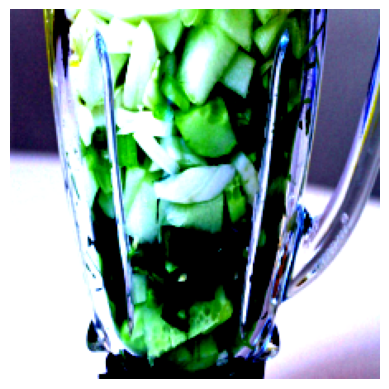


Actual captions: 
=>  A blender glass with several green vegetables in it.
=>  Many green vegetables are in the top of a blender.
=>  The blender pitcher is full of chopped vegetables.
=>  a blender filled with a lot of sliced cucumber 
=>  Some green vegetables that are in a blender.

Predicted Caption =>  A blender containing a pink smoothie, resting on a counter.



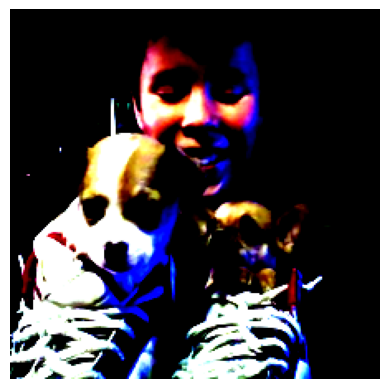


Actual captions: 
=>  A boy holds two small dogs each in a large sneaker.
=>  Two small chihuahua dogs sitting in side a boys shoes.
=>  a young boy looking at two little dogs sitting in tennis shoes 
=>  A boy smiles while two little dogs are inside of two tennis shoes.
=>  A smiling boy has dogs in tennis shoes.

Predicted Caption =>  A teenager with acne, holding up a black cat.



In [156]:
import matplotlib.pyplot as plt
for i in range(5):
    test = tuple(tuple(x) for x in captions_test[i][0])

    img, target = coco_dset[cembeds_img[test]]
    img_np = img.numpy().transpose((1, 2, 0))
    img_np = np.clip(img_np, 0, 1)

    plt.imshow(img_np)
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()
    print()
    print("Actual captions: ")
    for j in range(5):
      print("=> ",captions_test[i][1][j])
    print()
    print("Predicted Caption => " , best_ans[i])
    print()